In [3]:
# # 1. Carga y Configuración

# ## Importación de Librerías
# Importamos todas las herramientas necesarias para nuestro análisis.
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import optuna
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os

# Configuraciones iniciales
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

# Configuración del dispositivo (GPU si está disponible, de lo contrario CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# ## Carga de Datos
# Cargamos el dataset de entrenamiento.

# Asegúrate de que la ruta al archivo sea correcta
file_path = '../../Datos/df_train.parquet'

if not os.path.exists(file_path):
    print(f"Error: El archivo no se encuentra en la ruta especificada: {file_path}")
    print("Por favor, ajusta la variable 'file_path' a la ubicación correcta de tu archivo 'df_train.parquet'.")
    # Para que el resto del notebook pueda ejecutarse con datos de ejemplo, creamos un dataframe dummy.
    # EN UN CASO REAL, DETENDRÍAS LA EJECUCIÓN AQUÍ.
    print("Creando un DataFrame de ejemplo para demostración...")
    data = {
        'anio': np.repeat(np.arange(2015, 2022), 52 * 10),
        'semana': np.tile(np.repeat(np.arange(1, 53), 10), 7),
        'id_bar': np.tile(np.arange(1, 11), 52 * 7),
        'dengue': np.random.randint(0, 20, 52 * 7 * 10),
        'ESTRATO': np.random.randint(1, 6, 52 * 7 * 10),
        'temp_mean': np.random.uniform(20, 30, 52 * 7 * 10),
        'precip_sum': np.random.uniform(0, 50, 52 * 7 * 10)
    }
    df = pd.DataFrame(data)
    df = df.sort_values(by=['anio', 'semana', 'id_bar']).reset_index(drop=True)
else:
    df = pd.read_parquet(file_path)

print("Forma inicial de los datos:", df.shape)
print("Primeras filas de los datos:")
print(df.head())

Usando dispositivo: cuda
Forma inicial de los datos: (3680, 20)
Primeras filas de los datos:
          id  id_bar  anio  semana  ESTRATO  area_barrio  dengue  \
0  4_2015_01       4  2015       1      3.0        0.560     0.0   
1  5_2015_01       5  2015       1      3.0        0.842     0.0   
2  3_2015_01       3  2015       1      1.0        0.781     0.0   
3  8_2015_01       8  2015       1      2.0        0.394     0.0   
4  9_2015_01       9  2015       1      2.0        0.292     0.0   

   concentraciones  vivienda  equipesado  sumideros  maquina  lluvia_mean  \
0              0.0       0.0         0.0        0.0      0.0     0.000651   
1              0.0       0.0         0.0        0.0      0.0     0.000651   
2              0.0       0.0         0.0        0.0      0.0     0.000651   
3              0.0       0.0         0.0        0.0      0.0     0.000651   
4              0.0       0.0         0.0        0.0      0.0     0.000651   

   lluvia_var  lluvia_max  lluvia_m

In [4]:
# Eliminamos los registros donde la columna 'semana' es igual a 53
df = df[df['semana'] != 53].reset_index(drop=True)
print(f"Datos después de eliminar semana 53: {df.shape}")
print(df['semana'].value_counts())

Datos después de eliminar semana 53: (3640, 20)
semana
1     70
2     70
3     70
4     70
5     70
6     70
7     70
8     70
9     70
10    70
11    70
12    70
13    70
14    70
15    70
16    70
17    70
18    70
19    70
20    70
21    70
22    70
23    70
24    70
25    70
26    70
27    70
28    70
29    70
30    70
31    70
32    70
33    70
34    70
35    70
36    70
37    70
38    70
39    70
40    70
41    70
42    70
43    70
44    70
45    70
46    70
47    70
48    70
49    70
50    70
51    70
52    70
Name: count, dtype: Int64


In [5]:
# # 2. Análisis Exploratorio y Preprocesamiento

# ## Creación de la Fecha y Establecimiento del Índice
# Combinamos `anio` y `semana` en una fecha ISO, que es fundamental para manejar correctamente las series de tiempo.
def get_iso_date(row):
    """Convierte año y semana ISO a un objeto de fecha (lunes de esa semana)."""
    return datetime.fromisocalendar(int(row['anio']), int(row['semana']), 1)

df['fecha'] = df.apply(get_iso_date, axis=1)
df = df.sort_values(by=['fecha', 'id_bar']).set_index('fecha')
print("\nDatos con índice de fecha:")
print(df.head())


# ## Codificación de Variables Categóricas y Escalado
# Preparamos los datos para el modelo.
target_col = 'dengue'
categorical_features = ['id_bar', 'ESTRATO']
numeric_features = [col for col in df.columns if df[col].dtype != 'object' and col not in categorical_features + [target_col, 'anio', 'semana']]

print(f"\nVariable Objetivo: {target_col}")
print(f"Variables Categóricas: {categorical_features}")
print(f"Variables Numéricas (Covariables): {numeric_features}")

# Aplicamos One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)
encoded_cols = [col for col in df_encoded.columns if any(cat_col in col for cat_col in categorical_features)]
final_numeric_features = numeric_features + encoded_cols

# Escalado de datos
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
df_scaled = df_encoded.copy()
df_scaled[final_numeric_features] = feature_scaler.fit_transform(df_encoded[final_numeric_features])
df_scaled[target_col] = target_scaler.fit_transform(df_encoded[[target_col]])

print("\nDatos preprocesados y escalados:")
print(df_scaled.head())

# ## División de Datos en Entrenamiento y Validación
train_df = df_scaled[df_scaled['anio'] < 2021]
val_df = df_scaled[df_scaled['anio'] >= 2021]

train_df = train_df.drop(columns=['anio', 'semana'])
val_df = val_df.drop(columns=['anio', 'semana'])

model_features = [target_col] + final_numeric_features
X_train_df = train_df[model_features]
y_train_df = train_df[[target_col]]
X_val_df = val_df[model_features]
y_val_df = val_df[[target_col]]

print(f"\nForma del conjunto de entrenamiento: {X_train_df.shape}")
print(f"Forma del conjunto de validación: {X_val_df.shape}")


Datos con índice de fecha:
                   id  id_bar  anio  semana  ESTRATO  area_barrio  dengue  \
fecha                                                                       
2014-12-29  0_2015_01       0  2015       1      2.0        1.196     0.0   
2014-12-29  1_2015_01       1  2015       1      1.0        0.600     0.0   
2014-12-29  2_2015_01       2  2015       1      2.0        0.780     0.0   
2014-12-29  3_2015_01       3  2015       1      1.0        0.781     0.0   
2014-12-29  4_2015_01       4  2015       1      3.0        0.560     0.0   

            concentraciones  vivienda  equipesado  sumideros  maquina  \
fecha                                                                   
2014-12-29              0.0       0.0         0.0        0.0      0.0   
2014-12-29              0.0       0.0         0.0        0.0      0.0   
2014-12-29              0.0       0.0         0.0        0.0      0.0   
2014-12-29              0.0       0.0         0.0        0.0      0

In [ ]:
# # 3. Creación de Secuencias

# Los modelos LSTM requieren que los datos de entrada tengan una forma específica: [muestras, pasos_de_tiempo, características].
def create_sequences(input_data, target_data, window_size):
    """Crea secuencias y etiquetas para el modelo LSTM."""
    X, y = [], []
    for i in range(len(input_data) - window_size):
        X.append(input_data[i:(i + window_size)])
        y.append(target_data[i + window_size])
    return np.array(X), np.array(y)

WINDOW_SIZE = 32 # 52 semanas (1 año)

X_train, y_train = create_sequences(X_train_df.values, y_train_df.values, WINDOW_SIZE)
X_val, y_val = create_sequences(X_val_df.values, y_val_df.values, WINDOW_SIZE)

print(f"\nForma de las secuencias de entrenamiento (X): {X_train.shape}")
print(f"Forma de las etiquetas de entrenamiento (y): {y_train.shape}")
print(f"Forma de las secuencias de validación (X): {X_val.shape}")
print(f"Forma de las etiquetas de validación (y): {y_val.shape}")

# Convertir a tensores de PyTorch
X_train_tensor = torch.from_numpy(X_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)
X_val_tensor = torch.from_numpy(X_val).float().to(device)
y_val_tensor = torch.from_numpy(y_val).float().to(device)


Forma de las secuencias de entrenamiento (X): (3068, 52, 26)
Forma de las etiquetas de entrenamiento (y): (3068, 1)
Forma de las secuencias de validación (X): (468, 52, 26)
Forma de las etiquetas de validación (y): (468, 1)


In [ ]:
# # 4. Optimización de Hiperparámetros con Optuna

# ## Definición del Modelo LSTM en PyTorch
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.dropout(lstm_out)
        last_time_step_out = out[:, -1, :]
        out = self.linear(last_time_step_out)
        return out

# ## Función `objective` para Optuna
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 3)
    hidden_size = trial.suggest_int('units', 32, 256, log=True)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])

    input_size = X_train.shape[2]
    output_size = 1

    model = LSTMModel(input_size, hidden_size, n_layers, output_size, dropout).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    epochs = 50 # Menos epochs para la optimización rápida
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val_tensor)
        val_loss = criterion(y_val_pred, y_val_tensor)
        
    return val_loss.item()

# ## Ejecución del Estudio de Optuna
print("\nIniciando optimización de hiperparámetros con Optuna...")
N_TRIALS = 50 # Puede tomar tiempo, ajustar si es necesario
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=N_TRIALS)

print("Optimización finalizada.")
print(f"Mejor trial (MSE): {study.best_value}")
print("Mejores hiperparámetros:")
best_params = study.best_params
print(best_params)

[I 2025-06-22 18:50:04,478] A new study created in memory with name: no-name-fa87151e-b379-405b-ab29-3df8e48dcaea



Iniciando optimización de hiperparámetros con Optuna...


[I 2025-06-22 18:50:11,021] Trial 0 finished with value: 0.0027306422125548124 and parameters: {'n_layers': 2, 'units': 110, 'dropout': 0.34291434965008294, 'learning_rate': 0.009510941625532041, 'batch_size': 128}. Best is trial 0 with value: 0.0027306422125548124.
[I 2025-06-22 18:50:13,492] Trial 1 finished with value: 0.0028081564232707024 and parameters: {'n_layers': 1, 'units': 58, 'dropout': 0.3653186099814495, 'learning_rate': 0.0003143000628455392, 'batch_size': 64}. Best is trial 0 with value: 0.0027306422125548124.
[I 2025-06-22 18:50:15,106] Trial 2 finished with value: 0.0029252779204398394 and parameters: {'n_layers': 2, 'units': 49, 'dropout': 0.2886194582982416, 'learning_rate': 0.0011324066388084019, 'batch_size': 128}. Best is trial 0 with value: 0.0027306422125548124.
[I 2025-06-22 18:50:18,049] Trial 3 finished with value: 0.0027254519518464804 and parameters: {'n_layers': 1, 'units': 229, 'dropout': 0.1998962641097319, 'learning_rate': 0.0043888284175564625, 'batch

Optimización finalizada.
Mejor trial (MSE): 0.00267779384739697
Mejores hiperparámetros:
{'n_layers': 3, 'units': 163, 'dropout': 0.24772901049697854, 'learning_rate': 0.0026096421381789684, 'batch_size': 128}



Re-entrenando el modelo final con los datos combinados (2015-2021)...
Forma de las secuencias completas (X): (3588, 52, 26)
Forma de las etiquetas completas (y): (3588, 1)
Epoch [10/100], Loss: 0.006676
Epoch [20/100], Loss: 0.006845
Epoch [30/100], Loss: 0.005915
Epoch [40/100], Loss: 0.005821
Epoch [50/100], Loss: 0.005571
Epoch [60/100], Loss: 0.007048
Epoch [70/100], Loss: 0.005018
Epoch [80/100], Loss: 0.004565
Epoch [90/100], Loss: 0.005629
Epoch [100/100], Loss: 0.003708
Entrenamiento final completado.


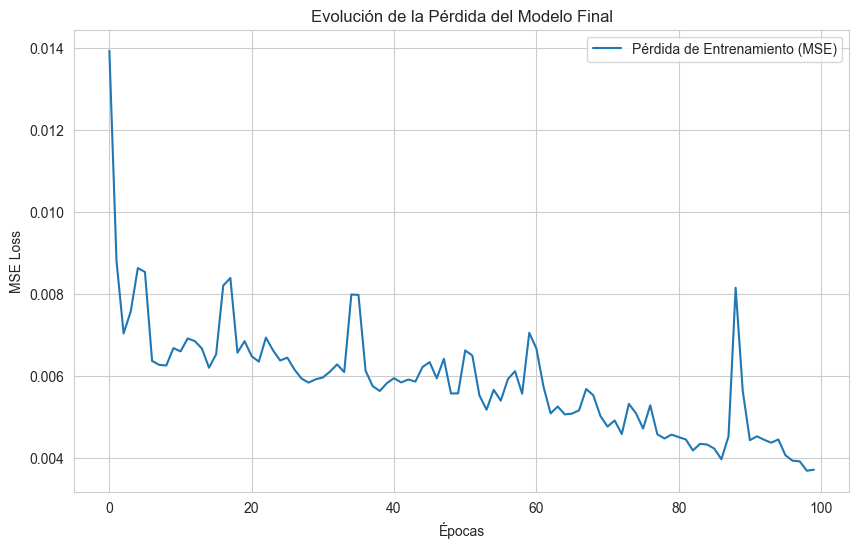

In [10]:
# # 5. Entrenamiento del Modelo Final

# ## Preparación de datos combinados
print("\nRe-entrenando el modelo final con los datos combinados (2015-2021)...")
full_df = pd.concat([X_train_df, X_val_df])
full_target_df = pd.concat([y_train_df, y_val_df])
X_full, y_full = create_sequences(full_df.values, full_target_df.values, WINDOW_SIZE)
X_full_tensor = torch.from_numpy(X_full).float().to(device)
y_full_tensor = torch.from_numpy(y_full).float().to(device)

print(f"Forma de las secuencias completas (X): {X_full.shape}")
print(f"Forma de las etiquetas completas (y): {y_full.shape}")

# ## Instanciación y Entrenamiento
input_size = X_full.shape[2]
output_size = 1

final_model = LSTMModel(
    input_size=input_size,
    hidden_size=best_params['units'],
    num_layers=best_params['n_layers'],
    output_size=output_size,
    dropout=best_params['dropout']
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])
batch_size = best_params['batch_size']

full_dataset = TensorDataset(X_full_tensor, y_full_tensor)
full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=True)

epochs = 100 # Más épocas para el modelo final
history = {'loss': []}

for epoch in range(epochs):
    final_model.train()
    epoch_loss = 0
    for X_batch, y_batch in full_loader:
        optimizer.zero_grad()
        y_pred = final_model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_epoch_loss = epoch_loss / len(full_loader)
    history['loss'].append(avg_epoch_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_epoch_loss:.6f}")
        
print("Entrenamiento final completado.")

# ## Gráfica del Historial de Entrenamiento
plt.figure(figsize=(10, 6))
plt.plot(history['loss'], label='Pérdida de Entrenamiento (MSE)')
plt.title('Evolución de la Pérdida del Modelo Final')
plt.xlabel('Épocas')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [11]:
# # 6. Generación de Pronósticos para 2022

print("\nGenerando pronósticos para 2022 de forma autorregresiva...")

weeks_to_forecast = 52
unique_barrios = df['id_bar'].unique()
all_forecasts = []

# Suposición crítica: Usar covariables de 2021 para 2022.
covariates_2021 = df_scaled[df_scaled['anio'] == 2021].copy()
covariates_2021['semana'] = covariates_2021.index.isocalendar().week
covariates_2021['id_bar'] = df[df['anio'] == 2021]['id_bar']

final_model.eval()
with torch.no_grad():
    for id_b in unique_barrios:
        print(f"  Pronosticando para el barrio: {id_b}")
        
        last_year_data = val_df[val_df[f'id_bar_{id_b}']==1] if f'id_bar_{id_b}' in val_df.columns else val_df
        if len(last_year_data) < WINDOW_SIZE:
             print(f"    Advertencia: Datos insuficientes para {id_b} en 2021. Saltando...")
             continue
        
        current_sequence = last_year_data[model_features].values[-WINDOW_SIZE:]

        for week_num in range(1, weeks_to_forecast + 1):
            input_tensor = torch.from_numpy(current_sequence).float().unsqueeze(0).to(device)
            scaled_prediction = final_model(input_tensor).item()
            
            unscaled_prediction = target_scaler.inverse_transform(np.array([[scaled_prediction]]))
            unscaled_prediction = max(0, unscaled_prediction[0][0])
            
            all_forecasts.append({
                'id_bar': id_b, 'anio': 2022, 'semana': week_num, 'dengue': unscaled_prediction
            })

            future_covariates = covariates_2021[
                (covariates_2021['id_bar'] == id_b) & (covariates_2021['semana'] == week_num)
            ]
            
            if future_covariates.empty:
                new_row_features = current_sequence[-1, 1:] 
            else:
                new_row_features = future_covariates[final_numeric_features].values[0]
            
            new_row = np.insert(new_row_features, 0, scaled_prediction)
            current_sequence = np.vstack([current_sequence[1:], new_row])

print("Generación de pronósticos completada.")


Generando pronósticos para 2022 de forma autorregresiva...
  Pronosticando para el barrio: 0
  Pronosticando para el barrio: 1
  Pronosticando para el barrio: 2
  Pronosticando para el barrio: 3
  Pronosticando para el barrio: 4
  Pronosticando para el barrio: 5
  Pronosticando para el barrio: 6
  Pronosticando para el barrio: 7
  Pronosticando para el barrio: 8
  Pronosticando para el barrio: 9
Generación de pronósticos completada.


In [ ]:
from datetime import datetime

# # 7. Creación del Archivo de Submission

# Convertimos la lista de pronósticos en un DataFrame y le damos el formato solicitado.
forecast_df = pd.DataFrame(all_forecasts)

# Crear la columna 'id' con el formato [id_bar]_[anio]_[semana]
forecast_df['id'] = forecast_df.apply(
    lambda row: f"{int(row['id_bar'])}_{int(row['anio'])}_{int(row['semana']):02d}",
    axis=1
)

# Seleccionar y redondear la columna de dengue
submission_df = forecast_df[['id', 'dengue']]
submission_df['dengue'] = submission_df['dengue'].round().astype(int)

# Guardar el archivo final
fecha_actual = datetime.now().strftime('%Y%m%d')
output_filename = f'pronosticos_dengue_2022_{fecha_actual}.csv'
submission_df.to_csv(output_filename, index=False)

print(f"\nArchivo de pronósticos guardado como '{output_filename}'")
print("Primeras filas del archivo de salida:")
print(submission_df.head())
print("\nÚltimas filas del archivo de salida:")
print(submission_df.tail())


Archivo de pronósticos guardado como 'pronosticos_dengue_2022.csv'
Primeras filas del archivo de salida:
          id  dengue
0  0_2022_01       2
1  0_2022_02       1
2  0_2022_03       1
3  0_2022_04       1
4  0_2022_05       1

Últimas filas del archivo de salida:
            id  dengue
515  9_2022_48      18
516  9_2022_49      15
517  9_2022_50       7
518  9_2022_51       6
519  9_2022_52       7
